In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf


In [24]:
import keras
keras.__version__
from keras import models
from keras import layers


In [25]:
path = 'bridge.jpg'
ng = 64
nd = 64
no_of_styles = 4

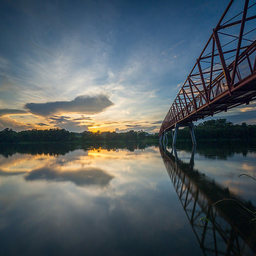

In [26]:
gimage = Image.open(path)
gimage

In [27]:
image = cv2.imread(path)
image = cv2.resize(image, (128, 128))
#image =  Image.BICUBIC(image)
image.shape

(128, 128, 3)

In [39]:
from keras.layers.advanced_activations import ReLU
from keras.engine.input_layer import Input
from keras.layers import BatchNormalization
from keras.layers import Lambda

def encoder():
  input = Input(shape=(128, 128, 3))
  #Reflection padding
  input_pad = Lambda(lambda x: tf.pad(x, [[0,0], [27,27], [27,27], [0,0]], 'REFLECT'))(input) 
  layer1 = layers.Conv2D(ng, kernel_size=(7, 7))(input_pad)
  layer1 = BatchNormalization(axis=[0,1])(layer1) #instance normalization
  layer1 = ReLU()(layer1)

  in_f = ng
  op_f = ng*2

  layer2 = layers.Conv2D(op_f, kernel_size=(3, 3), stride=2, padding =1)(layer1) 
  layer2 = BatchNormalization(axis=[0,1])(layer2) #instance normalization
  layer2 = ReLU()(layer2)

  in_f = op_f
  op_f = op_f * 2

  layer3 = layers.Conv2D(op_c, kernel_size=(3, 3), stride=2, padding =1)(layer2)
  layer3 = BatchNormalization(axis=[0,1])(layer3) #instance normalization
  layer3 = ReLU()(layer3)

  in_f = op_f
  op_f = op_f * 2
  
  model = models.Model([input], layer3)
  
  return model


In [40]:
from keras.layers.advanced_activations import ReLU
from keras.engine.input_layer import Input
from keras.layers import BatchNormalization
from keras.layers import Lambda
from keras.layers.convolutional import Conv2DTranspose

class Generator():
  def __init__(self, n_styles, ng, x):
    super(Generator, self).__init__()

    self.encoder = encoder(ng, x)
    self.transformer = transformer(x, no_of_styles, ng)
    self.decoder = decoder(x, ng)

  def __call__(self,x):
    e = self.encoder(x)
    t = self.transformer(e)
    d = self.decoder(t)
    return d


  def encoder(self, ng, x):
    input = Input(shape=(128, 128, 3))
    #Reflection padding
    model = Lambda(lambda x: tf.pad(x, [[0,0], [27,27], [27,27], [0,0]], 'REFLECT'))(input) 
    model = layers.Conv2D(ng, kernel_size=(7, 7))(model)
    model = BatchNormalization(axis=[0,1])(model) #instance normalization
    model = ReLU()(model)

    #in_f = ng
    op_f = ng * 2

    model = layers.Conv2D(op_f, kernel_size=(3, 3), stride=2, padding =1)(model) 
    model = BatchNormalization(axis=[0,1])(model) #instance normalization
    model = ReLU()(model)

    #in_f = op_f
    op_f = op_f * 2

    model = layers.Conv2D(op_f, kernel_size=(3, 3), stride=2, padding =1)(model)
    model = BatchNormalization(axis=[0,1])(model) #instance normalization
    model = ReLU()(model)

    in_f = op_f
    op_f = op_f * 2
    
    self.model = keras.Sequential(*model)

    
    return [self.model(x['content']), x['style_label']]

  def residual_block(self, in_f, x):

    res_block = [Lambda(lambda x: tf.pad(x, [[0,0], [27,27], [27,27], [0,0]], 'REFLECT')),
                layers.Conv2D(in_f, kernel_size=(3, 3)),
                BatchNormalization(in_f, axis=[0,1]),
                ReLU(),
                Lambda(lambda x: tf.pad(x, [[0,0], [27,27], [27,27], [0,0]], 'REFLECT')),
                layers.Conv2D(in_f, kernel_size=(3, 3)),
                BatchNormalization(in_f, axis=[0,1]),
                ReLU()              
    ]
    self.res_block = keras.Sequential(*res_block)
    return x + self.res_block(x)

  def transformer(self, x, no_of_styles, ng):
    tr = []
    for i in range(no_of_styles):
#      r = self.residual_block( ng*4, x )
      tr = tr.append(self.residual_block(ng*4, x))
    self.t = tr  
    self.t.append(x)

    label = x[1][0]
    trans_content = np.sum([self.t[i](x[0])*j for (i,j) in enumerate(label) if j])
    return trans_content

  def decoder(self, x, ng):
    in_f = ng * 4
    op_f = in_f//2
    dmodel = []
    for i in range(5):
      dmodel += [self.residual_block(in_f)]

    for i in range(2):
      dmodel += [ Conv2DTranspose(op_f, (3, 3), stride=2, padding =1),
                 BatchNormalization(op_f, axis=[0,1]),
                 ReLU()                 
      ]
      op_f = op_f//2

    dmodel += [ Lambda(lambda x: tf.pad(x, [[0,0], [27,27], [27,27], [0,0]], 'REFLECT')),
                Conv2D(3, (7, 7), stride=2, padding =1),
                Tanh()]

    self.dmodel = keras.Sequential(*dmodel)
    return self.dmodel


In [ ]:
class Discriminator():
  def __init__(self, no_of_styles, nd):
    op_f = nd
    dismodel = []
    for i in range(2):
      dismodel += [layers.Conv2D(op_f, kernel_size=(4, 4), stride=2, padding = 2),
                BatchNormalization(op_f, axis=[0,1]),
                LeakyReLU(alpha = 0.3)]

      op_f = op_f * 2
    dismodel += [layers.Conv2D(op_f, kernel_size=(4, 4), stride = 1, padding = 2),
                BatchNormalization(op_f, axis=[0,1]),
                LeakyReLU(alpha = 0.3)]
                
    self.dismodel = keras.Sequential(*dismodel)

    self.discriminator = layers.Conv2D(1, kernel_size=(4, 4), padding = 2)
    self.classification = layers.Conv2D(4, kernel_size=(4, 4), padding = 2)
  
  def __call__(self, x):
    base =  self.dismodel(x)
    discriminate = self.discriminator(base)
    classifier = self.classification(base).transpose(1,3)
    return [discriminate, classifier]